<a href="https://colab.research.google.com/github/shoreOwl125/SFSU-Coursework/blob/main/Deep-Learning/ResNet-18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSC 871 Project - Flower Image Classification using ResNet18 vs Simple CNN
By Andrew Dahlstrom, Laurent Amat, Marie Shimizu, Gautami Gudla

In [ ]:
import os
import torch
import random
import tqdm
import time
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

In [ ]:
# Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

seed = 16
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(f"Seed set to {seed}")

Using cuda device
Seed set to 16


In [ ]:
%%capture
!wget -O dataset.zip https://github.com/Lqvrent/DL-Team09/archive/bddf774157c701a4c0237d407ff4e33ae0429550.zip
!unzip dataset.zip
!mv DL-Team09-bddf774157c701a4c0237d407ff4e33ae0429550 github_repo

# Hyper parameters
epochs = 10
lr = 1e-4
batch_size = 64
num_classes = 14 # Should NOT be changed
default_weights = ResNet18_Weights.IMAGENET1K_V1

In [ ]:
# Data transformation
class ConditionalGrayscale:
    def __call__(self, img):
        if img.mode != 'RGB':
            grayscale_transform = transforms.Grayscale(num_output_channels=3)
            img = grayscale_transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ConditionalGrayscale(), # 3 channel grayscale for greyscale images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, category = self.data[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, category

    def load_data(self):
        data = []
        with open(self.csv_file, 'r') as file:
            lines = file.readlines()
            for line in lines[1:]:
                image_path, category = line.strip().split(',')
                image_path = os.path.join('github_repo/dataset', image_path)
                data.append((image_path, int(category)))
        return data

    def get_category_name(self, category):
        # get a human readable category name
        category_name = None
        for image_path, cat in self.data:
            if cat == category:
                category_name = image_path.split('/')[-2]
                break
        return category_name

Val dataset size:    98
Train dataset size:  13642
  carnation          924
  iris               1041
  bellflower         872
  california_poppy   1021
  rose               986
  astilbe            726
  tulip              1034
  calendula          1011
  dandelion          1038
  coreopsis          1035
  black_eyed_susan   986
  water_lily         977
  sunflower          1013
  common_daisy       978


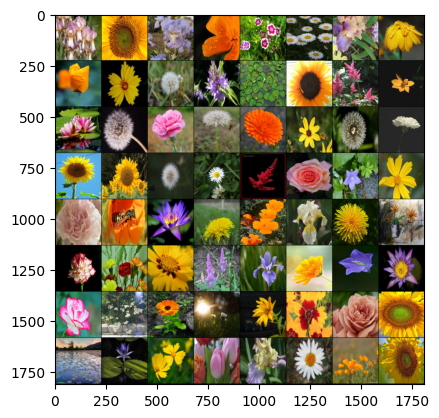

In [ ]:
# Load train data and validation data
train_dataset = MyDataset(csv_file='./github_repo/dataset/train.csv', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyDataset(csv_file='./github_repo/dataset/val.csv', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Val dataset size:   ", len(val_dataset))
print("Train dataset size: ", len(train_dataset))
for i in range(14):
    category_name = train_dataset.get_category_name(i)
    count = len([x for x in train_dataset.data if x[1] == i])
    print(f"  {category_name.ljust(18)} {count}")

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
sample_img = iter(train_dataloader)
images, labels = next(sample_img)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# Simple CNN Model Architecture adapted from PyTorch.org training manual
class CNN(nn.Module):
    # num_classes = 14
    def __init__(self, num_classes):
        super().__init__()
        # (# of input channels, # of output channels, kernel size, padding)
        self.conv1 = nn.Conv2d(3, 12, 3, padding=1)
        # First batch normalization layer
        self.bn1 = nn.BatchNorm2d(12)
        # pooling window 2 = 2x2, stride 2 = 2 left x 2 down
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(24)
        # Additional convolutional layer added
        self.conv3 = nn.Conv2d(24, 48, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        # (input vector size, output vector size)
        self.fc1 = nn.Linear(48 * 28 * 28, 120)
        # Dropout layer
        self.dropout = nn.Dropout(.5)
        self.fc2 = nn.Linear(120, 84)
        # The output size = num_classes
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = F.relu(self.bn1(self.conv1(x)))
        # Apply max pooling to reduce the dimensions of the output
        x = self.pool(x)
        # Apply the second convolutional layer followed by ReLU activation and pooling layer
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        # Apply the third convolutional layer followed by ReLU activation and pooling layer
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        # Flatten the output of the last pooling layer to a single long feature vector
        # The flatten operation maintains the batch size on the 0th dimension and flattens the rest
        x = torch.flatten(x, 1)
        # Pass the flattened vector through the first fully connected layer followed by ReLU activation function
        x = F.relu(self.fc1(x))
        # Apply dropout layer
        x = self.dropout(x)
        # Pass the output of the previous fully connected layer through another fully connected layer followed by ReLU
        x = F.relu(self.fc2(x))
        # Pass the output of the previous layer through the final fully connected layer which outputs the logits for each class
        # Logits are the raw scores needed for the cross-entropy loss function during training
        x = self.fc3(x)
        return x

# Instantiate the network with 14 classes
cnn = CNN(num_classes)
cnn = cnn.to(device)
# Use Adam optimizer to learning rate optimization
optimizer_cnn = optim.Adam(cnn.parameters(), lr=lr)

# Initialize loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss_cnn = []
train_accuracy_cnn = []
val_accuracy_cnn = []

for epoch in range(epochs):
    # Training loop
    # Set the model to training mode
    cnn.train()

    running_loss = 0.0
    train_correct = 0
    train_total = 0

    # Loop over batch of data in train_dataloader
    for inputs, labels in tqdm.tqdm(train_dataloader, desc=f"Train (CNN) - Epoch {epoch+1}"):
        # Move input and label tensors that are being trained on to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients computed in the previous step before backward pass
        optimizer_cnn.zero_grad()
        # Compute the model's predictions for the batch of data (forward pass)
        outputs = cnn(inputs)
        # Calculate loss between predictions and labels based on CrossEntropyLoss
        loss = criterion(outputs, labels)
        # Compute the gradients of the loss based on the model's parameters (backward pass)
        loss.backward()
        # Perform an optimization step to update model's parameters
        optimizer_cnn.step()
        # Accumulate loss
        running_loss += loss.item()
        # Compute the number of correct predictions by comparing to the true labels
        # Take the max class logit value per image and assign corresponding class
        _, predicted = torch.max(outputs.data, 1)
        # Total number of labels
        train_total += labels.size(0)
        # Total number of correctly predicted labels
        train_correct += (predicted == labels).sum().item()
    # After all batches have been processed, calculate average loss and accuracy for epoch
    train_loss_cnn.append(running_loss / len(train_dataloader))
    train_accuracy_cnn.append(100 * train_correct / train_total)

    # Validation loop
    # Set the model to evaluation mode
    cnn.eval()
    val_correct = 0
    val_total = 0
    # We don't need to compute gradients during validation
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Compute the model's redictions for the validation batch (forward pass)
            outputs = cnn(inputs)
            # Get class prediction by finding max logit value '_' is the index of
            # the max value corresponding to predicted class
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # After all validation data has been processed for epoch compute accuracy
    val_accuracy_cnn.append(100 * val_correct / val_total)

    # Logging
    print(f"Epoch {epoch + 1} (CNN) loss: {train_loss_cnn[-1]}")
    print(f"(CNN) Training accuracy: {train_accuracy_cnn[-1]}%")
    print(f"(CNN) Validation accuracy: {val_accuracy_cnn[-1]}%")
    print()

Train (CNN) - Epoch 1: 100%|██████████| 214/214 [01:07<00:00,  3.18it/s]


Epoch 1 (CNN) loss: 2.2172569621389155
(CNN) Training accuracy: 25.62674094707521%
(CNN) Validation accuracy: 47.95918367346939%



Train (CNN) - Epoch 2: 100%|██████████| 214/214 [00:59<00:00,  3.62it/s]


Epoch 2 (CNN) loss: 1.8645854982260233
(CNN) Training accuracy: 36.49758099985339%
(CNN) Validation accuracy: 46.93877551020408%



Train (CNN) - Epoch 3: 100%|██████████| 214/214 [00:59<00:00,  3.61it/s]


Epoch 3 (CNN) loss: 1.7176655341531628
(CNN) Training accuracy: 40.85178126374432%
(CNN) Validation accuracy: 47.95918367346939%



Train (CNN) - Epoch 4: 100%|██████████| 214/214 [00:59<00:00,  3.62it/s]


Epoch 4 (CNN) loss: 1.6275390832223624
(CNN) Training accuracy: 43.95982993695939%
(CNN) Validation accuracy: 48.97959183673469%



Train (CNN) - Epoch 5: 100%|██████████| 214/214 [00:58<00:00,  3.65it/s]


Epoch 5 (CNN) loss: 1.5384874238032047
(CNN) Training accuracy: 46.466793725260224%
(CNN) Validation accuracy: 50.0%



Train (CNN) - Epoch 6: 100%|██████████| 214/214 [00:58<00:00,  3.65it/s]


Epoch 6 (CNN) loss: 1.4925551353213944
(CNN) Training accuracy: 48.55593021551092%
(CNN) Validation accuracy: 52.04081632653061%



Train (CNN) - Epoch 7: 100%|██████████| 214/214 [00:59<00:00,  3.57it/s]


Epoch 7 (CNN) loss: 1.4385457105725725
(CNN) Training accuracy: 50.161266676440405%
(CNN) Validation accuracy: 57.142857142857146%



Train (CNN) - Epoch 8: 100%|██████████| 214/214 [00:59<00:00,  3.61it/s]


Epoch 8 (CNN) loss: 1.4062544040590803
(CNN) Training accuracy: 50.615745491863365%
(CNN) Validation accuracy: 56.12244897959184%



Train (CNN) - Epoch 9: 100%|██████████| 214/214 [00:58<00:00,  3.67it/s]


Epoch 9 (CNN) loss: 1.3645582271513539
(CNN) Training accuracy: 52.199091042369155%
(CNN) Validation accuracy: 58.16326530612245%



Train (CNN) - Epoch 10: 100%|██████████| 214/214 [00:57<00:00,  3.69it/s]


Epoch 10 (CNN) loss: 1.3230359426168639
(CNN) Training accuracy: 53.577188095587154%
(CNN) Validation accuracy: 65.3061224489796%



In [ ]:
# ResNet18 model without training weights
resnet = models.resnet18(weights=None)
resnet.fc = nn.Linear(512, num_classes)
resnet = resnet.to(device)
# Use Adam optimizer to learning rate optimization
optimizer_resnet = optim.Adam(resnet.parameters(), lr=lr)

In [ ]:
train_loss_resnet = []
train_accuracy_resnet = []
val_accuracy_resnet = []

for epoch in range(epochs):
    # Training loop
    resnet.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm.tqdm(train_dataloader, desc=f"Train (ResNet18) - Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_loss_resnet.append(running_loss / len(train_dataloader))
    train_accuracy_resnet.append(100 * train_correct / train_total)

    # Validation loop
    resnet.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accuracy_resnet.append(100 * val_correct / val_total)

    # Logging
    print(f"Epoch {epoch + 1} (ResNet18) loss: {train_loss_resnet[-1]}")
    print(f"(ResNet18) Training accuracy: {train_accuracy_resnet[-1]}%")
    print(f"(ResNet18) Validation accuracy: {val_accuracy_resnet[-1]}%")
    print()

# Save the model as model-timestamp.pth
# torch.save(net.state_dict(), f"./model-{int(time.time())}.pth")

Train (ResNet18) - Epoch 1: 100%|██████████| 214/214 [01:19<00:00,  2.70it/s]


Epoch 1 (ResNet18) loss: 1.4596973172972136
(ResNet18) Training accuracy: 50.12461515906759%
(ResNet18) Validation accuracy: 50.0%



Train (ResNet18) - Epoch 2: 100%|██████████| 214/214 [01:20<00:00,  2.65it/s]


Epoch 2 (ResNet18) loss: 1.0290499404769078
(ResNet18) Training accuracy: 65.01246151590676%
(ResNet18) Validation accuracy: 60.204081632653065%



Train (ResNet18) - Epoch 3: 100%|██████████| 214/214 [01:19<00:00,  2.68it/s]


Epoch 3 (ResNet18) loss: 0.846529260138485
(ResNet18) Training accuracy: 71.05996188242193%
(ResNet18) Validation accuracy: 64.28571428571429%



Train (ResNet18) - Epoch 4: 100%|██████████| 214/214 [01:19<00:00,  2.69it/s]


Epoch 4 (ResNet18) loss: 0.7140954276111638
(ResNet18) Training accuracy: 75.53877730538045%
(ResNet18) Validation accuracy: 74.48979591836735%



Train (ResNet18) - Epoch 5: 100%|██████████| 214/214 [01:19<00:00,  2.70it/s]


Epoch 5 (ResNet18) loss: 0.6196412338274662
(ResNet18) Training accuracy: 78.72012901334115%
(ResNet18) Validation accuracy: 72.44897959183673%



Train (ResNet18) - Epoch 6: 100%|██████████| 214/214 [01:20<00:00,  2.65it/s]


Epoch 6 (ResNet18) loss: 0.5473206339874
(ResNet18) Training accuracy: 81.70356252748864%
(ResNet18) Validation accuracy: 70.40816326530613%



Train (ResNet18) - Epoch 7: 100%|██████████| 214/214 [01:20<00:00,  2.67it/s]


Epoch 7 (ResNet18) loss: 0.48678575574516136
(ResNet18) Training accuracy: 83.21360504324879%
(ResNet18) Validation accuracy: 81.63265306122449%



Train (ResNet18) - Epoch 8: 100%|██████████| 214/214 [01:19<00:00,  2.68it/s]


Epoch 8 (ResNet18) loss: 0.4060261475844918
(ResNet18) Training accuracy: 86.67350828324292%
(ResNet18) Validation accuracy: 80.61224489795919%



Train (ResNet18) - Epoch 9: 100%|██████████| 214/214 [01:20<00:00,  2.67it/s]


Epoch 9 (ResNet18) loss: 0.3496488057007299
(ResNet18) Training accuracy: 88.61603870400235%
(ResNet18) Validation accuracy: 81.63265306122449%



Train (ResNet18) - Epoch 10: 100%|██████████| 214/214 [01:21<00:00,  2.63it/s]


Epoch 10 (ResNet18) loss: 0.3059340215801636
(ResNet18) Training accuracy: 89.75956604603431%
(ResNet18) Validation accuracy: 75.51020408163265%



In [ ]:
# ResNet18 model using training weights from ImageNet
resnetPT = models.resnet18(weights=default_weights)
resnetPT.fc = nn.Linear(512, num_classes)
resnetPT = resnetPT.to(device)
# Use Adam optimizer to learning rate optimization
optimizer_resnetPT = optim.Adam(resnetPT.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [ ]:
train_loss_resnetPT = []
train_accuracy_resnetPT = []
val_accuracy_resnetPT = []

for epoch in range(epochs):
    # Training loop
    resnetPT.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm.tqdm(train_dataloader, desc=f"Train (ResNet18) - Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnetPT.zero_grad()
        outputs = resnetPT(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnetPT.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_loss_resnetPT.append(running_loss / len(train_dataloader))
    train_accuracy_resnetPT.append(100 * train_correct / train_total)

    # Validation loop
    resnetPT.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnetPT(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accuracy_resnetPT.append(100 * val_correct / val_total)

    # Logging
    print(f"Epoch {epoch + 1} (ResNet18) loss: {train_loss_resnetPT[-1]}")
    print(f"(ResNet18) Training accuracy: {train_accuracy_resnetPT[-1]}%")
    print(f"(ResNet18) Validation accuracy: {val_accuracy_resnetPT[-1]}%")
    print()

Train (ResNet18) - Epoch 1: 100%|██████████| 214/214 [01:19<00:00,  2.68it/s]


Epoch 1 (ResNet18) loss: 0.4326855576484003
(ResNet18) Training accuracy: 88.11024776425744%
(ResNet18) Validation accuracy: 94.89795918367346%



Train (ResNet18) - Epoch 2: 100%|██████████| 214/214 [01:20<00:00,  2.67it/s]


Epoch 2 (ResNet18) loss: 0.11402638293976818
(ResNet18) Training accuracy: 96.8772907198358%
(ResNet18) Validation accuracy: 95.91836734693878%



Train (ResNet18) - Epoch 3: 100%|██████████| 214/214 [01:19<00:00,  2.69it/s]


Epoch 3 (ResNet18) loss: 0.06537131613085621
(ResNet18) Training accuracy: 98.2773786834775%
(ResNet18) Validation accuracy: 95.91836734693878%



Train (ResNet18) - Epoch 4: 100%|██████████| 214/214 [01:20<00:00,  2.66it/s]


Epoch 4 (ResNet18) loss: 0.048564368821941664
(ResNet18) Training accuracy: 98.71719689195133%
(ResNet18) Validation accuracy: 95.91836734693878%



Train (ResNet18) - Epoch 5: 100%|██████████| 214/214 [01:19<00:00,  2.69it/s]


Epoch 5 (ResNet18) loss: 0.030880673818951734
(ResNet18) Training accuracy: 99.12036358305234%
(ResNet18) Validation accuracy: 97.95918367346938%



Train (ResNet18) - Epoch 6: 100%|██████████| 214/214 [01:20<00:00,  2.67it/s]


Epoch 6 (ResNet18) loss: 0.01900645140580241
(ResNet18) Training accuracy: 99.5528514880516%
(ResNet18) Validation accuracy: 97.95918367346938%



Train (ResNet18) - Epoch 7: 100%|██████████| 214/214 [01:19<00:00,  2.68it/s]


Epoch 7 (ResNet18) loss: 0.01949005142435275
(ResNet18) Training accuracy: 99.48687875678053%
(ResNet18) Validation accuracy: 97.95918367346938%



Train (ResNet18) - Epoch 8: 100%|██████████| 214/214 [01:20<00:00,  2.65it/s]


Epoch 8 (ResNet18) loss: 0.009662740510261713
(ResNet18) Training accuracy: 99.78742119923764%
(ResNet18) Validation accuracy: 97.95918367346938%



Train (ResNet18) - Epoch 9: 100%|██████████| 214/214 [01:19<00:00,  2.68it/s]


Epoch 9 (ResNet18) loss: 0.022166827965036
(ResNet18) Training accuracy: 99.3915848116112%
(ResNet18) Validation accuracy: 97.95918367346938%



Train (ResNet18) - Epoch 10: 100%|██████████| 214/214 [01:19<00:00,  2.69it/s]


Epoch 10 (ResNet18) loss: 0.015578734163503884
(ResNet18) Training accuracy: 99.58217270194986%
(ResNet18) Validation accuracy: 98.9795918367347%



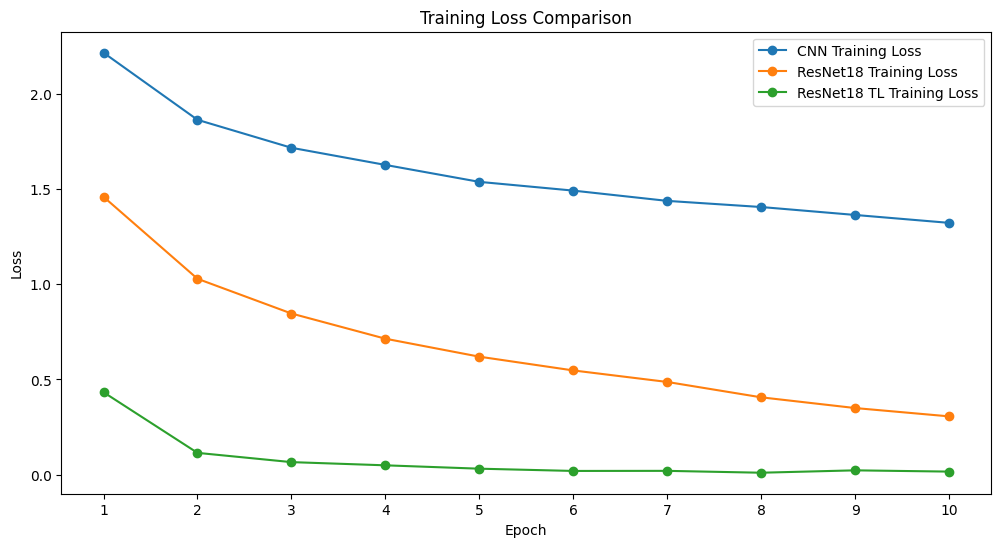

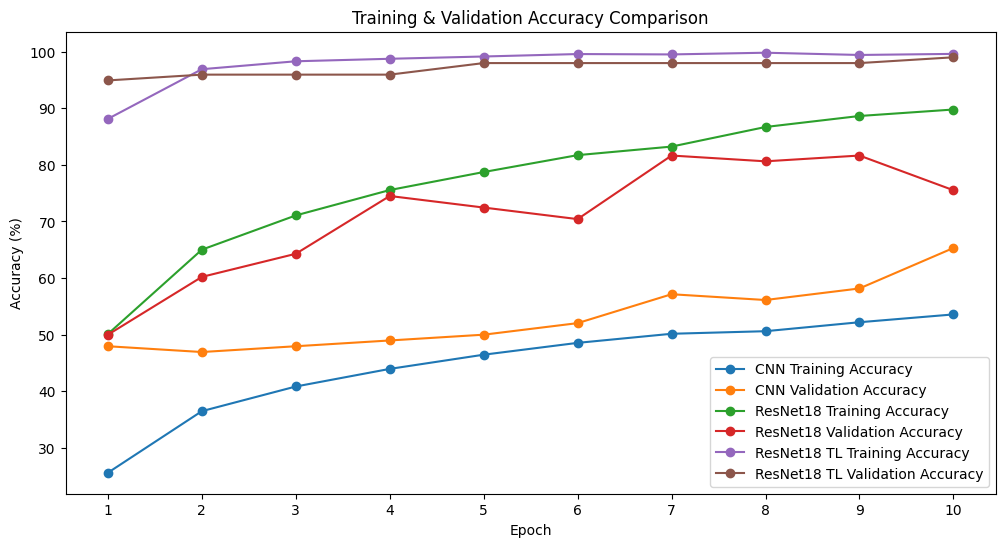

In [ ]:
# Setting arbitrary x-axis tick marks to begin at epoch 1
x_tick_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x_tick_positions = range(0, len(x_tick_labels))

# Plotting section for Training Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_cnn, 'o-', label='CNN Training Loss')
plt.plot(train_loss_resnet, 'o-', label='ResNet18 Training Loss')
plt.plot(train_loss_resnetPT, 'o-', label='ResNet18 TL Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.xticks(x_tick_positions, x_tick_labels)
plt.legend()
plt.show()

# Plotting section for Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_cnn, 'o-', label='CNN Training Accuracy')
plt.plot(val_accuracy_cnn, 'o-', label='CNN Validation Accuracy')
plt.plot(train_accuracy_resnet, 'o-', label='ResNet18 Training Accuracy')
plt.plot(val_accuracy_resnet, 'o-', label='ResNet18 Validation Accuracy')
plt.plot(train_accuracy_resnetPT, 'o-', label='ResNet18 TL Training Accuracy')
plt.plot(val_accuracy_resnetPT, 'o-', label='ResNet18 TL Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy Comparison')
plt.xticks(x_tick_positions, x_tick_labels)
plt.legend()
plt.show()

References:

PyTorch simple Convolution Neural Network tutorial
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html